In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import pandas as pd

# Import data and create DataFrame of data to augment
X_train = np.load('../data/processed/train.npz')['x']
y_train = np.load('../data/processed/train.npz')['y']
X_v = np.load('../data/processed/v.npz')['x']
y_v = np.load('../data/processed/v.npz')['y']

In [2]:
import json
import xgboost as xgb

def amex_metric(y_true, y_pred):
    'Calculate the custom AMEX evalutaion metric'
    '''
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])
    '''
    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    #return 0.5 * (gini[1] / gini[0] + top_four)
    return gini[1] / gini[0]

def amex_scorer(preds, dtrain):
    y = dtrain.get_label()
    return 'amex', amex_metric(y, preds)

with open('../config/xgboost.json', 'r') as f:
    params = json.load(f)
params['seed'] = 0
dtrain = xgb.DMatrix(X_train, y_train)
dv = xgb.DMatrix(X_v, y_v)
bst = xgb.train(params, dtrain, num_boost_round=9999, verbose_eval=100,
                evals=[(dtrain, 'train'), (dv, 'v')], custom_metric=amex_scorer, 
                early_stopping_rounds=100, maximize=True)
preds = bst.predict(dv, iteration_range=(0, bst.best_iteration + 1))

In [3]:
from ctgan import TVAE

synthesizer = TVAE.load('../outputs/synthesizers/tuning/0.pkl')
synth = synthesizer.sample(len(X_train) // 10)
X_synth = synth.drop('target', axis=1).values
y_synth = np.array(synth['target'])
X_train_aug = np.vstack((X_train, X_synth))
y_train_aug = np.concatenate((y_train, y_synth))

dtrain_aug = xgb.DMatrix(X_train_aug, y_train_aug)
bst = xgb.train(params, dtrain_aug, num_boost_round=9999, verbose_eval=100,
                evals=[(dtrain_aug, 'train'), (dv, 'v')], custom_metric=amex_scorer, 
                early_stopping_rounds=100, maximize=True)
preds_tvae = bst.predict(dv, iteration_range=(0, bst.best_iteration + 1))

[0]	train-logloss:0.60043	train-amex:0.83956	v-logloss:0.56180	v-amex:0.80316
[100]	train-logloss:0.24153	train-amex:0.91990	v-logloss:0.24335	v-amex:0.90609
[200]	train-logloss:0.22770	train-amex:0.92736	v-logloss:0.23207	v-amex:0.91273
[300]	train-logloss:0.22152	train-amex:0.93112	v-logloss:0.22831	v-amex:0.91531
[400]	train-logloss:0.21749	train-amex:0.93355	v-logloss:0.22646	v-amex:0.91662
[500]	train-logloss:0.21439	train-amex:0.93541	v-logloss:0.22524	v-amex:0.91749
[600]	train-logloss:0.21185	train-amex:0.93694	v-logloss:0.22441	v-amex:0.91810
[700]	train-logloss:0.20965	train-amex:0.93828	v-logloss:0.22387	v-amex:0.91850
[800]	train-logloss:0.20756	train-amex:0.93954	v-logloss:0.22325	v-amex:0.91896
[900]	train-logloss:0.20565	train-amex:0.94068	v-logloss:0.22279	v-amex:0.91930
[1000]	train-logloss:0.20393	train-amex:0.94171	v-logloss:0.22259	v-amex:0.91946
[1100]	train-logloss:0.20229	train-amex:0.94268	v-logloss:0.22236	v-amex:0.91963
[1200]	train-logloss:0.20067	train-amex:

In [4]:
preds_int = np.array([round(e) for e in preds])
preds_tvae_int = np.array([round(e) for e in preds_tvae])

In [5]:
(preds_int == preds_tvae_int).sum() # most are equal

49230

In [6]:
# from wrong to right
wrong_right = (preds_int != preds_tvae_int) & (preds_tvae_int == y_v) & (preds_int != y_v)
print(wrong_right.sum())
right_wrong = (preds_int != preds_tvae_int) & (preds_tvae_int != y_v) & (preds_int == y_v)
print(right_wrong.sum())

397
373


In [7]:
y_v[wrong_right].sum() / wrong_right.sum()

0.45843828715365237

In [8]:
y_v[right_wrong].sum() / right_wrong.sum()

0.4879356568364611

In [9]:
(preds_int == y_v).sum()

45036

In [11]:
X_wrong_right = X_v[wrong_right]
y_wrong_right = y_v[wrong_right]
X_right_wrong = X_v[right_wrong]
y_right_wrong = y_v[right_wrong]

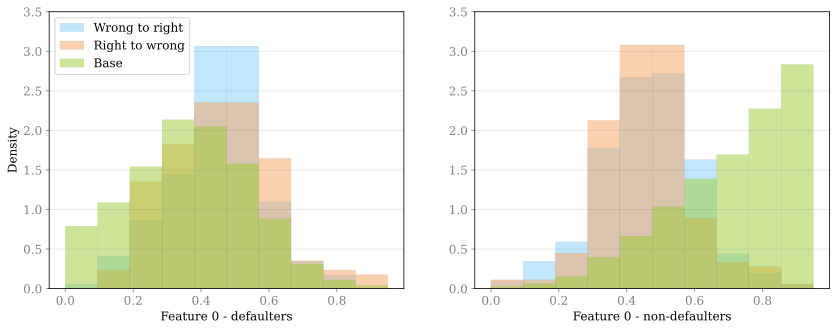

In [21]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Feature 0
min_v, max_v = 0, 0.95
bin_width = (max_v - min_v) / 10
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
axes[0].hist(X_wrong_right[y_wrong_right == 1, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.5, density=True, label='Wrong to right')
axes[0].hist(X_right_wrong[y_right_wrong == 1, 0], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.5, density=True, label='Right to wrong')
axes[0].hist(X_v[y_v == 1, 0], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.5, density=True, label='Base')
axes[0].set_xlabel('Feature 0 - defaulters')
axes[0].set_ylabel('Density')
axes[0].grid(axis='x')
axes[0].legend(loc='upper left')
axes[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

axes[1].hist(X_wrong_right[y_wrong_right == 0, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.5, density=True)
axes[1].hist(X_right_wrong[y_right_wrong == 0, 0], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.5, density=True)
axes[1].hist(X_v[y_v == 0, 0], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.5, density=True)
axes[1].set_xlabel('Feature 0 - non-defaulters')
axes[1].grid(axis='x')
axes[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]);

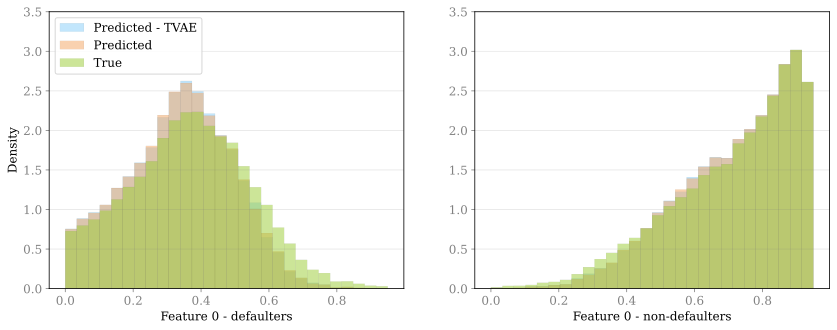

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Feature 0
min_v, max_v = 0, 0.95
bin_width = (max_v - min_v) / 28
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
axes[0].hist(X_v[preds_tvae_int == 1, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.5, density=True, label='Predicted - TVAE')
axes[0].hist(X_v[preds_int == 1, 0], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.5, density=True, label='Predicted')
axes[0].hist(X_v[y_v == 1, 0], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.5, density=True, label='True')
axes[0].set_xlabel('Feature 0 - defaulters')
axes[0].set_ylabel('Density')
axes[0].grid(axis='x')
axes[0].legend(loc='upper left')
axes[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])

axes[1].hist(X_v[preds_tvae_int == 0, 0], bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.5, density=True)
axes[1].hist(X_v[preds_int == 0, 0], bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.5, density=True)
axes[1].hist(X_v[y_v == 0, 0], bins=bin_edges, edgecolor='dimgray', color='yellowgreen', lw=0.1, alpha=0.5, density=True)
axes[1].set_xlabel('Feature 0 - non-defaulters')
axes[1].grid(axis='x')
axes[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]);

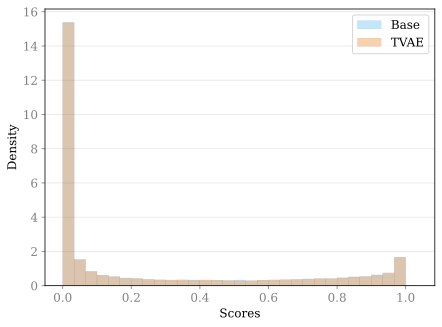

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# Feature 0
min_v, max_v = 0, 1
bin_width = (max_v - min_v) / 30
bin_edges = np.arange(min_v, max_v + bin_width, bin_width)
ax.hist(preds, bins=bin_edges, edgecolor='dimgray', color='lightskyblue', lw=0.1, alpha=0.5, density=True, label='Base')
ax.hist(preds_tvae, bins=bin_edges, edgecolor='dimgray', color='sandybrown', lw=0.1, alpha=0.5, density=True, label='TVAE')
ax.set_xlabel('Scores')
ax.set_ylabel('Density')
ax.grid(axis='x')
ax.legend(loc='upper right');

In [27]:
preds

array([0.00184338, 0.97021914, 0.04446963, ..., 0.12345221, 0.99812573,
       0.52149653], dtype=float32)